# Trabajo Práctico 1
## Business Analytics / Aplicaciones Computacionales en Negocios
### Amigo, Caracoix, Marsili y Sanson

#### Setup del entorno, carga de los datos y armado de funciones básicas

In [3]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
import matplotlib as plt
import random
import math
from IPython.display import Markdown as md

from typing import List, Tuple

In [4]:
# Cargamos el dataset de viento
datos = pd.read_excel('wind_data.xlsx')

La funcion $\theta$ esta definida como:

$$
\theta(i) = 6 + 2cos(2πi/365)
$$

In [5]:
def theta_function(i):
    return 6 + 2 * np.cos(2 * np.pi * i / 365)

El error en la regresión lineal, conocido como RMSE (raiz del error cuadratico medio o root mean squared error), está definido como:

$$
RMSE = \sqrt{\frac{1}{n} \sum_{i=1}^{n} (y_i - \hat{y}_i)^2}
$$

In [6]:
def calcular_RMSE(Y, predicciones):

    n = len(Y)

    residuos = Y - predicciones
    varianza = np.sum(residuos**2) / n

    return np.sqrt(varianza)

##### Por último, establecemos parámetros básicos que nos van a acompañar durante todo el trabajo

In [7]:
N = 10000 # Cantidad de simulaciones/iteraciones que se haran en cada ejercicio

T = 365 # Período en el cual se realizará el análisis

k_inicial = 5 # La media a ojo del viento

C = 200000 # Costo de arreglo inicial

# Ejercicio 1

### Regresion Lineal para el modelo del viento regional

Vamos a estimar los parámetros $\kappa$ y $\sigma$ para el regresion_vientoo de velocidad del viento regional utilizando un regresion_vientoo de regresion lineal.

La ecuación original es:

$$
S_{i+1} = S_i + \kappa (\theta(t_i) - S_i) \Delta + \sigma \sqrt{\Delta} Z_i
$$

Despejamos $S_i$ para obtener una forma adecuada para la regresión lineal:

$$
S_{i+1} - S_i = \kappa \Delta (\theta(t_i) - S_i) + \sigma \sqrt{\Delta} Z_i
$$

Reescribimos la ecuación en términos de $\beta$:

$$
Y = \beta_1 X  + \epsilon_i
$$

donde:
- $Y = S_{i+1} - S_i$
- $\beta_1 = \kappa \Delta$
- $\epsilon_i = \sigma \sqrt{\Delta} Z_i$

Luego, generamos las columnas correspndientes en nuestro dataset: 

In [8]:
datos['Y'] = datos['regional wind'].diff()  # Calcula la diferencia entre días consecutivos

# Preparar X, que es theta_i - S_i 
datos['X'] = theta_function(datos["dia"]) - datos['regional wind'].shift(1)

# Eliminar los valores nulos generados por diff() y shift()
datos = datos.dropna(subset=['Y', 'X'])

In [9]:
Y = datos['Y'] # Variable a predecir
X = datos[['X']] # Variable predictora

regresion_viento = LinearRegression()
regresion_viento.fit(X, Y)

B0 = regresion_viento.intercept_
B1 = regresion_viento.coef_[0]

delta = 1/T

#Estimamos kappa
kappa_estimado = B1 / delta

#Estimamos sigma
predicciones = regresion_viento.predict(X)

error = calcular_RMSE(Y,predicciones)

sigma_estimado = error / np.sqrt(delta)

print(f"kappa estimado: {kappa_estimado}")
print(f"sigma estimado: {sigma_estimado}")

kappa estimado: 108.73826243919804
sigma estimado: 16.046573595261595


### Regresion Lineal para el modelo de diferencia de la velocidad del viento entre el norte y el sur

Vamos a estimar los parámetros $\beta$ y $\gamma$ para el regresion_vientoo de diferencia de la velocidad del viento entre el norte y el sur utilizando un modelo de regresion lineal.

La ecuación original es:

$$
D_{i+1} = D_i - \beta D_i \Delta + \gamma \sqrt{\Delta} W_i
$$

Despejamos $D_i$ para obtener una forma adecuada para la regresión lineal:

$$
D_{i+1} - D_i = - \beta \Delta D_i  + \gamma \sqrt{\Delta} W_i
$$

Reescribimos la ecuación en términos de $\beta$:

$$
H = \beta_1 G  + \epsilon_i
$$

donde:
- $H = D_{i+1} - D_i$
- $\beta_1 = -\beta \Delta$
- $\epsilon_i = \gamma \sqrt{\Delta} W_i$

Repetimos el mismo proceso que realizamos antes:

In [10]:
# Preparar H
datos['H'] = datos['wind gap norte sur'].diff()

# Eliminar los valores nulos generados por diff()
datos = datos.dropna(subset = ('H'))

In [11]:
G = datos[['wind gap norte sur']]
H = datos['H']

regresion_gap = LinearRegression()
regresion_gap.fit(G,H)

B0_2 = regresion_gap.intercept_
B1_2 = regresion_gap.coef_[0]

#Estimamos beta
beta_estimado = -B1_2 / delta

#Estimamos gamma

predicciones_gap = regresion_gap.predict(G)

error_gap = calcular_RMSE(H,predicciones_gap)

gamma_estimado = error_gap / np.sqrt(delta)

print(f"beta estimado: {beta_estimado}")
print(f"gamma estimado: {gamma_estimado}")

beta estimado: -48.37880318325385
gamma estimado: 10.091915756839064


# Ejercicio 2

##### Creamos funciones básicas para simular el viento y el gap, y una función para realizar N simulaciones

In [12]:
def generar_viento_regional(kappa, sigma, T):
    camino_viento = np.zeros(T)
    camino_viento[0] = datos['regional wind'].iloc[0] #PREGUNTAR ESTO

    for i in range(1, T):
        Z = np.random.normal(0, 1)
        camino_viento[i] = camino_viento[i-1] + kappa * (theta_function(i) - camino_viento[i-1]) * 1/T + sigma * np.sqrt(1/T) * Z

    return camino_viento

def generar_gap_norte_sur(beta, gamma, T):
    camino_gap = np.zeros(T)
    camino_gap[0] = datos['wind gap norte sur'].iloc[0] #PREGUNTAR ESTO

    for i in range(1, T):
        W = np.random.normal(0, 1)
        camino_gap[i] = camino_gap[i-1] + beta * 1/T * camino_gap[i-1] + gamma * np.sqrt(1/T) * W

    return camino_gap

def generar_simulaciones(N,T):
    
    n_caminos = []

    for i in range(N):
        simular_viento = generar_viento_regional(kappa_estimado, sigma_estimado, T)
        simular_gap = generar_gap_norte_sur(beta_estimado, gamma_estimado, T)

        camino_norte = simular_viento - simular_gap / 2
        camino_sur = simular_viento + simular_gap / 2

        n_caminos.append((camino_norte,camino_sur))

    print("Simulaciones generadas exitosamente")
        
    return n_caminos


In [13]:
N_simulaciones = generar_simulaciones(N,T)

simulacion_regional = generar_simulaciones(1,T)

simulacion_norte = simulacion_regional[0][0]

simulacion_sur = simulacion_regional[0][1]

Simulaciones generadas exitosamente
Simulaciones generadas exitosamente


$$
\text{Simulación Norte} = S_i + \frac{D_i}{2}
$$

$$
\text{Simulación Sur} = S_i - \frac{D_i}{2}
$$

Luego, si tomamos el promedio:

$$
\frac{\left(S_i + \frac{D_i}{2}\right) + \left(S_i - \frac{D_i}{2}\right)}{2} = S_i
$$

Simplificando:

$$
\frac{S_i + \frac{D_i}{2} + S_i - \frac{D_i}{2}}{2} = \frac{2S_i}{2} = S_i
$$

### Grafico comparativo del viento regional real vs el simulado

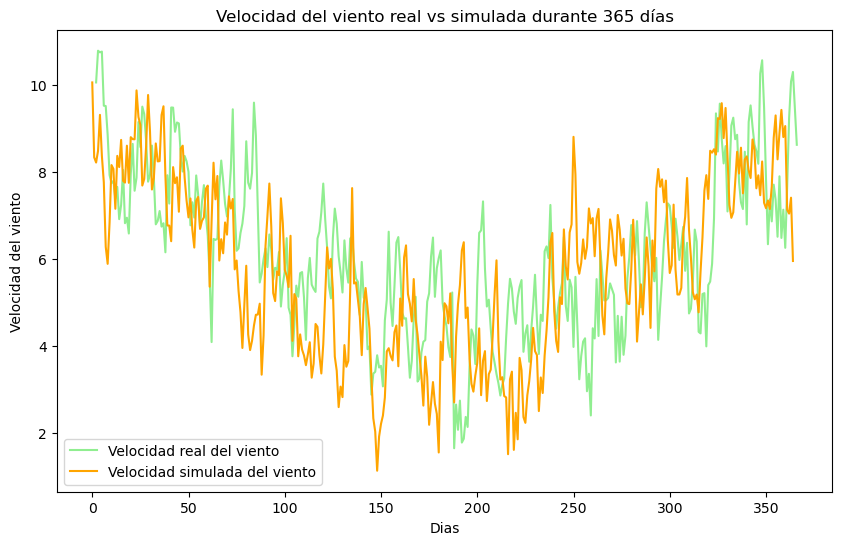

In [14]:
import matplotlib.pyplot as plt

simular_viento = (simulacion_norte + simulacion_sur) / 2

# Graficar la velocidad del viento
plt.figure(figsize=(10, 6))
plt.plot(datos['regional wind'][:T], color='lightgreen', label='Velocidad real del viento')
plt.plot(simular_viento, color='orange', label='Velocidad simulada del viento')

# Añadir etiquetas y título
plt.xlabel('Dias')
plt.ylabel('Velocidad del viento')
plt.title('Velocidad del viento real vs simulada durante 365 días')

# Añadir leyenda
plt.legend()

# Mostrar el gráfico
plt.show()

Vemos que en el largo plazo, hay una correlacion positiva entre ambos, por lo que resulta razonable pensar que el camino simulado se parece al camino real

### Grafico comparativo de la diferencia de velocidad del viento entre el norte y el sur real vs la simulada

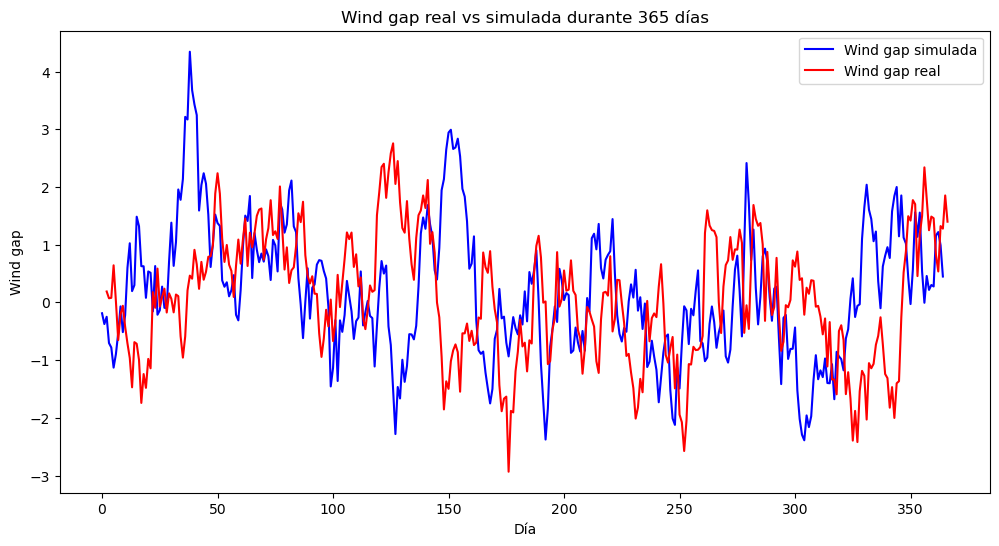

In [15]:
simular_gap = simulacion_norte - simulacion_sur

# Graficar las simulaciones
plt.figure(figsize=(12, 6))
plt.plot(simular_gap, color='blue', label='Wind gap simulada')
plt.plot(datos["wind gap norte sur"][:T], color='red', label='Wind gap real')

plt.xlabel('Día')
plt.ylabel('Wind gap')
plt.title('Wind gap real vs simulada durante 365 días')
plt.legend()
plt.show()


### Gráfico comparativo de la velocidad simulada del viento para los molinos norte y sur

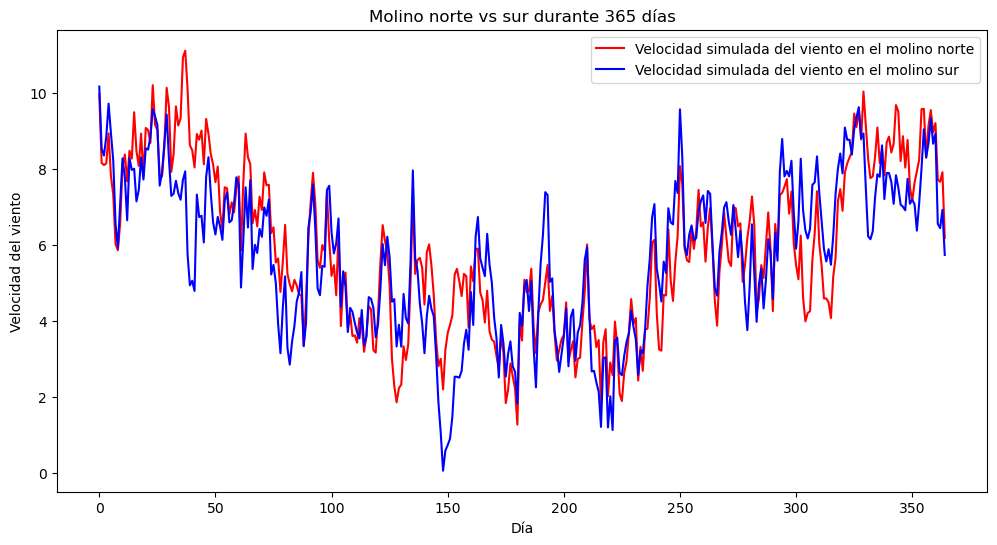

In [16]:
plt.figure(figsize=(12, 6))
plt.plot(simulacion_norte, color='red', label='Velocidad simulada del viento en el molino norte')
plt.plot(simulacion_sur, color='blue', label='Velocidad simulada del viento en el molino sur')

plt.xlabel('Día')
plt.ylabel('Velocidad del viento')
plt.title('Molino norte vs sur durante 365 días')
plt.legend()
plt.show()

Si bien hay periodos dentro del corto plazo donde la correlacion no es positiva, en el largo plazo ambos caminos se expanden de la misma manera, con correlación positiva

# Ejercicio 3

In [17]:
def simular_rotura(p):
    return 1 if random.uniform(0,1) < p else 0

def calcular_VAN(T, viento, k, costo_arreglo):
    delta = 1/T
    S = viento
    activo = False
    VAN = 0
    VAN_diario = []

    estado_molino = []
    rotura = []

    for i in range(0, T):
        tasa_descuento = math.exp(-0.05 * i / 365)

        probabilidad_rotura = 0.25*(S[i]**2)*delta
        if(activo):
            esta_roto = simular_rotura(probabilidad_rotura)

            if(esta_roto):
                VAN -= costo_arreglo
                activo = False
                rotura.append(1)
            
            else:

                rotura.append(0)

                if(S[i] >= k):
                    activo = False
                    VAN -= 1000

                else:
                    VAN += 1000 * S[i]
        
        else:

            if(S[i] < k):
                activo = True
                VAN += 1000 * S[i]
        
            rotura.append(0)

        VAN = VAN * tasa_descuento

        VAN_diario.append(VAN)
        estado_molino.append(activo)
    
    return VAN_diario, estado_molino, rotura

def simular_ambos_molinos(sim_norte, sim_sur, T, k) -> List:

    VAN_molino_norte,estados_molino_norte,roturas_molino_norte = calcular_VAN(T,sim_norte,k,C)

    info_molino_norte = (VAN_molino_norte,estados_molino_norte,roturas_molino_norte)

    VAN_molino_sur,estados_molino_sur,roturas_molino_sur = calcular_VAN(T, sim_sur,k,C)

    info_molino_sur = (VAN_molino_sur,estados_molino_sur,roturas_molino_sur)

    return [info_molino_norte, info_molino_sur]

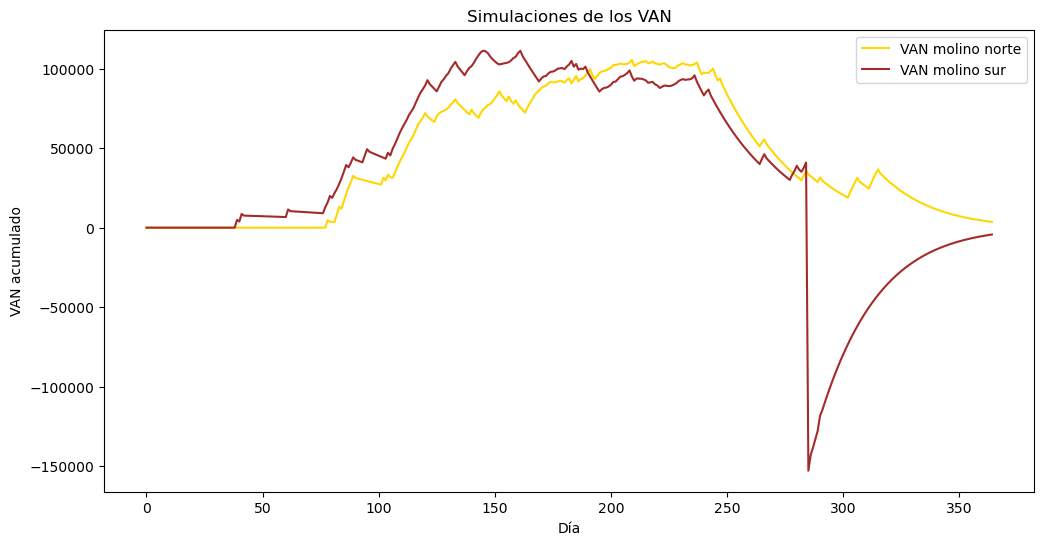

In [18]:
simulacion_ambos_molinos = simular_ambos_molinos(simulacion_norte,simulacion_sur, T, k_inicial)

simular_VAN_molino_norte = simulacion_ambos_molinos[0][0]

simular_VAN_molino_sur = simulacion_ambos_molinos[1][0]

# Graficar las simulaciones
plt.figure(figsize=(12, 6))
plt.plot(simular_VAN_molino_norte, color='gold', label='VAN molino norte')
plt.plot(simular_VAN_molino_sur, color='brown', label='VAN molino sur')

plt.xlabel('Día')
plt.ylabel('VAN acumulado')
plt.title('Simulaciones de los VAN')
plt.legend()
plt.show()

# Ejercicio 4

In [19]:
def graficar_estado_molino(sim,roturas,encendido,region,k):
    # Datos ya calculados: simulacion_norte (velocidad del viento), simular_encendido_norte (estado de encendido) y simular_rotura_norte (roturas)
    dias = np.arange(len(sim))

    # Graficar la velocidad del viento
    plt.figure(figsize=(10, 6))
    plt.plot(dias, sim, color='orange', label='Velocidad simulada del viento', linewidth=0.85)

    # Graficar línea verde o roja según el valor de simular_encendido_norte
    for i in range(len(sim) - 1):
        if encendido[i] == 1:  # Encendido (True)
            plt.plot([dias[i], dias[i+1]], [sim[i], sim[i+1]], color='green', linewidth=2)
        else:  # Apagado (False)
            plt.plot([dias[i], dias[i+1]], [sim[i], sim[i+1]], color='red', linewidth=2)

    # Graficar roturas con puntos en la posición donde ocurre una rotura (simular_rotura_norte == 1)
    rotura_indices = np.where(np.array(roturas) == 1)[0]
    plt.scatter(rotura_indices, np.array(sim)[rotura_indices], color='blue', label=f'Rotura molino {region}', zorder=5)

    # Graficar línea horizontal en y = 9
    plt.axhline(y=k, color='black', linestyle='--', label='Umbral de apagado')

    # Añadir etiquetas y título
    plt.xlabel('Días')
    plt.ylabel('Velocidad del viento')
    plt.title('Velocidad del viento real vs simulada con estado de encendido y roturas')

    # Añadir leyenda con colores personalizados
    legend_labels = ['Encendido (verde)', 'Apagado (rojo)', f'Rotura molino {region}', 'Umbral de apagado']
    legend_colors = ['green', 'red', 'blue', 'black']
    handles = [plt.Line2D([0], [0], color=color, lw=2) for color in legend_colors]
    plt.legend(handles, legend_labels)

    # Mostrar el gráfico
    plt.tight_layout()
    plt.show()

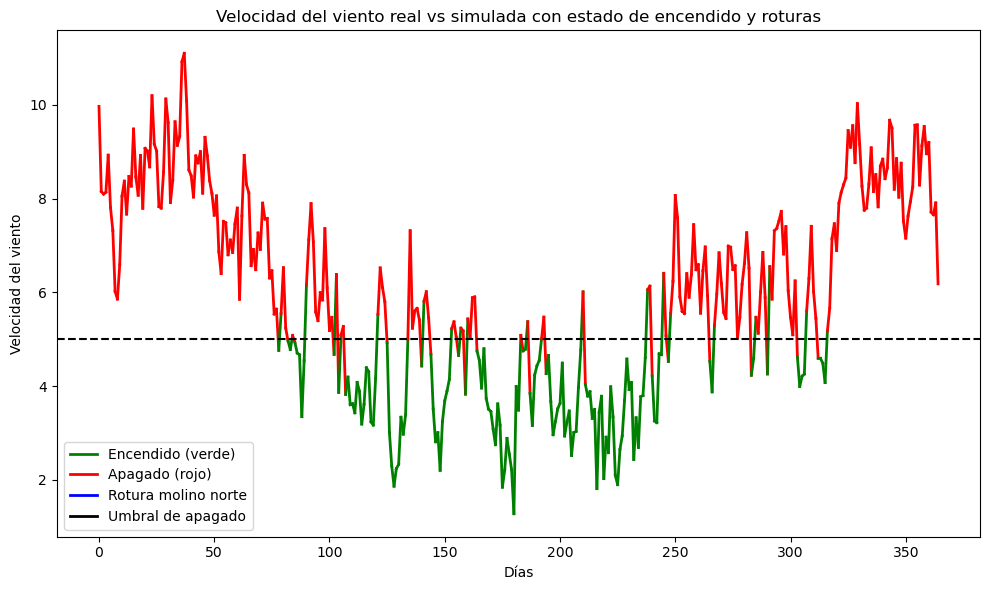

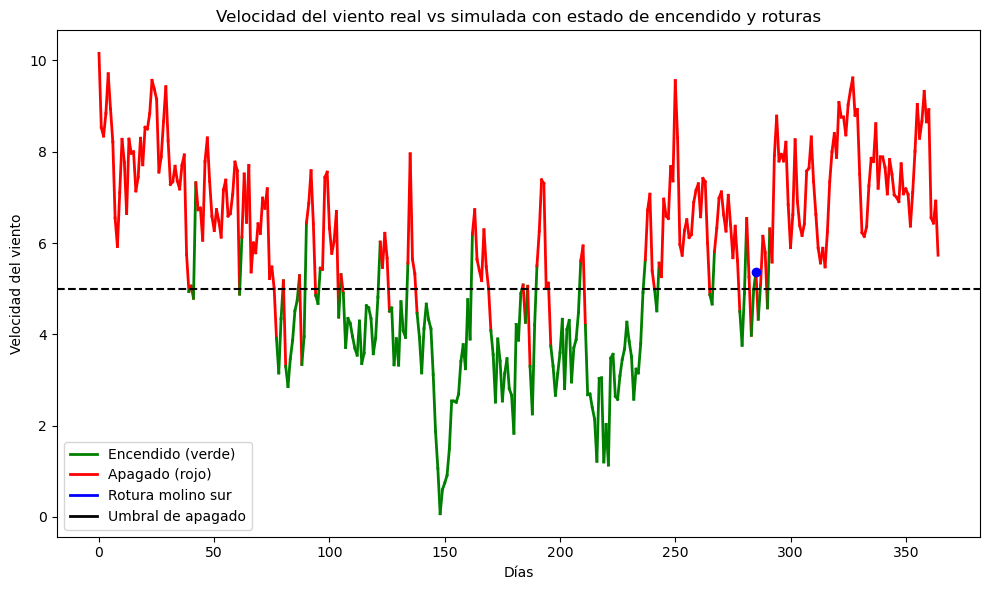

In [20]:
simular_encendido_norte = simulacion_ambos_molinos[0][1]

simular_rotura_norte = simulacion_ambos_molinos[0][2]

simular_norte = simulacion_ambos_molinos[0][0]

simular_encendido_sur = simulacion_ambos_molinos[1][1]

simular_rotura_sur = simulacion_ambos_molinos[1][2]

simular_sur = simulacion_ambos_molinos[1][0]

graficar_estado_molino(simulacion_norte,simular_rotura_norte,simular_encendido_norte,"norte", k_inicial)

graficar_estado_molino(simulacion_sur,simular_rotura_sur,simular_encendido_sur,"sur", k_inicial)


En el gráfico podemos observar como las 3 simulaciones se expanden de manera simetrica a traves del tiempo, esto nos lleva a pensar que los modelos implementados anteriormente son fieles a los datos proporcionados, mostrando una correlacion de largo plazo positiva.


A CHEQUEAR REY

# Ejercicio 5

El VAN esperado se calcula como el promedio de los VANs simulados:
$$
\text{VAN esperado} = \frac{1}{N} \sum_{j=1}^N \text{VAN}_j
$$

donde:
- N es el número total de simulaciones.
- $\text{VAN}_j$ es el VAN del j-ésimo camino simulado.


In [21]:
def VAN_esperado(k, N, T, simulaciones):

    simulaciones_regionales = []

    for i in range(N):

        VAN_norte = calcular_VAN(T, simulaciones[i][0], k,C)
        VAN_sur = calcular_VAN(T, simulaciones[i][1], k,C)

        simulaciones_regionales.append(VAN_norte + VAN_sur)

    VAN_esperado = np.mean(simulaciones_regionales)

    return(VAN_esperado)

El error de estimación del VAN esperado se calcula en dos pasos:

1. **Calcular la Desviación Estándar de los VANs Simulados**:

   La fórmula para la desviación estándar $\sigma_{\text{VAN}}$ es:
   $$
   \sigma_{\text{VAN}} = \sqrt{\frac{1}{N-1} \sum_{j=1}^N (\text{VAN}_j - \text{VAN esperado})^2}
   $$

   Donde:
   - N es el número total de simulaciones.
   - $\text{VAN}_j$ es el VAN del j-ésimo camino simulado.
   - $\text{VAN esperado}$ es el promedio de los VANs simulados.

2. **Calcular el Error Estándar del VAN Esperado**:

   La fórmula para el error estándar es:
   $$
   \text{Error estándar} = \frac{\sigma_{\text{VAN}}}{\sqrt{N}}
   $$

   Donde:
   - $\sigma_{\text{VAN}}$ es la desviación estándar de los VANs simulados.
   - N es el número total de simulaciones.


In [22]:
def estimar_error_muestral(datos):

    # Calcular la desviación estándar de los datos
    desviacion_estandar = np.std(datos, ddof=1)  # ddof=1 para obtener la desviación estándar muestral

    # Calcular el error estándar
    error_estandar = desviacion_estandar / np.sqrt(len(datos))

    return error_estandar

Decidimos implementar la funcion de estimar error para un conjunto de datos generico y no para el VAN esperado unicamente ya que luego la vamos a querer utilizar para estimar otros errores muestrales usando la misma formula

# Ejercicio 6

### Optimización del Umbral de Viento k para Maximizar el VAN

Queremos encontrar el valor del umbral de viento k que maximiza el Valor Actual Neto (VAN) generado por los molinos de viento en un año. Para ello, vamos utilizar simulaciones de Monte Carlo siguiendo estos pasos:

1. Definir un rango de valores de k
2. Implementar la simulación para calcular el VAN esperado para cada valor de k para N simulaciones.
3. Comparar los VANs obtenidos y seleccionar el k óptimo que maximice el VAN esperado.


In [ ]:
umbrales = np.arange(6, 10, 0.1)
lista_VANs_total = []

for k in umbrales:

    VAN_esperado_dado_k = VAN_esperado(k, N, T, N_simulaciones)
    lista_VANs_total.append((VAN_esperado_dado_k, k))

k_optimo = max(lista_VANs_total, key=lambda x: (x[0], x[1]))[1]  # Max en función de [VAN, k], solo devuelve k

print(f"El valor óptimo de k es: {k_optimo}")

# Ejercicio 7

Calculamos el VAN esperado para 10000 simulaciones (Monte Carlo) para ver a donde converge en cada tipo de operacion:

- Operacion optima: utilizando k = 7.5
- Operacion ingenua: utilizando k >> 7.5 (nunca se apaga el molino)

(Nota: Como puede variar el resultado del ejercicio anterior, seteamos el umbral a un valor fijo)

Luego comparamos los resultados

In [23]:
k_ingenuo = 10000
k_optimo = 7.5

VAN_esperado_ingenuo = VAN_esperado(k_ingenuo, N, T, N_simulaciones)
VAN_esperado_optimo = VAN_esperado(k_optimo, N, T, N_simulaciones)

print(f"VAN esperado con K-ingenuo: {VAN_esperado_ingenuo}")
print(f"VAN esperado con K-optimo: {VAN_esperado_optimo}")

VAN esperado con K-ingenuo: 5884.910650289609
VAN esperado con K-optimo: 8623.835790614285


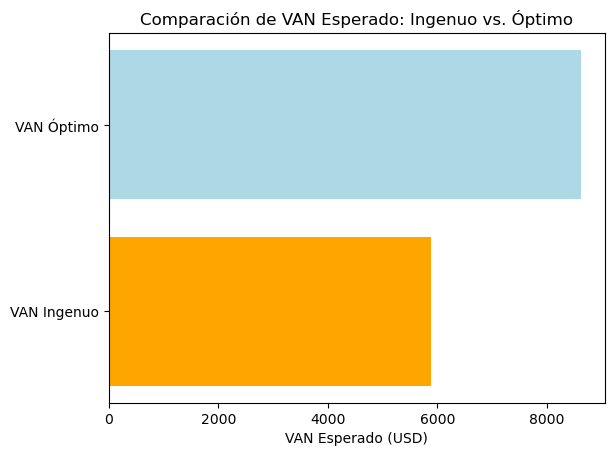

In [24]:
import matplotlib.pyplot as plt

# Nombres de las categorías
categorias = ['VAN Ingenuo', 'VAN Óptimo']

# Colores correspondientes a cada barra
colores = ['orange', 'lightblue']

# Crear gráfico de barras horizontal
plt.barh(categorias, [VAN_esperado_ingenuo, VAN_esperado_optimo], color=colores)

# Añadir etiquetas
plt.xlabel('VAN Esperado (USD)')
plt.title('Comparación de VAN Esperado: Ingenuo vs. Óptimo')

# Mostrar gráfico
plt.show()

# Ejercicio 8

Al ingreso del mes de Agosto lo podemos medir como el ingreso entre los días 213 (1 de Agosto) y 243 (31 de Agosto) de nuestro modelo.

Primero, implementamos una funcion para calcular el VAN sin comtemplar la tasa de descuento diaria:

In [25]:
def calcular_VAN_sin_descuento(T, viento, k):

    delta = 1/T
    S = viento
    activo = False
    VAN = 0
    VAN_diario = []
    estado_molino = []

    for i in range(0, T):

        probabilidad_rotura = 0.25*(S[i]**2)*delta

        if(activo):
            esta_roto = simular_rotura(probabilidad_rotura)

            if(esta_roto):
                activo = False
            
            else:
                if(S[i] >= k):
                    activo = False

                else:
                    VAN += 1000 * S[i]
        
        else:

            if(S[i] < k):
                activo = True
                VAN += 1000 * S[i]
        
        estado_molino.append(activo)

        VAN_diario.append(VAN)
    
    return VAN_diario, estado_molino

A traves de Monte Carlo, calculamos los ingresos de agosto para 10000 simulaciones distintas para despues poder graficar la distribucion del mismo

In [26]:
ingresos_agosto = []

for i in range(N):

    viento_norte_agosto = N_simulaciones[i][0]
    viento_sur_agosto = N_simulaciones[i][1]

    ingreso_norte_agosto = calcular_VAN_sin_descuento(len(viento_norte_agosto),viento_norte_agosto,k_optimo)[0][-1]
    ingreso_sur_agosto = calcular_VAN_sin_descuento(len(viento_sur_agosto),viento_sur_agosto,k_optimo)[0][-1]

    ingresos_agosto.append(ingreso_norte_agosto + ingreso_sur_agosto)

print(f"Estimación de error muestral: {estimar_error_muestral(ingresos_agosto)}")

print(f"Media de ingresos en Agosto sin descuento: {np.mean(ingresos_agosto)}")

Estimación de error muestral: 1427.3585090133167
Media de ingresos en Agosto sin descuento: 2846969.5393786295


Graficamos la distribucion de los ingresos de agosto a traves de un histograma de frecuencia

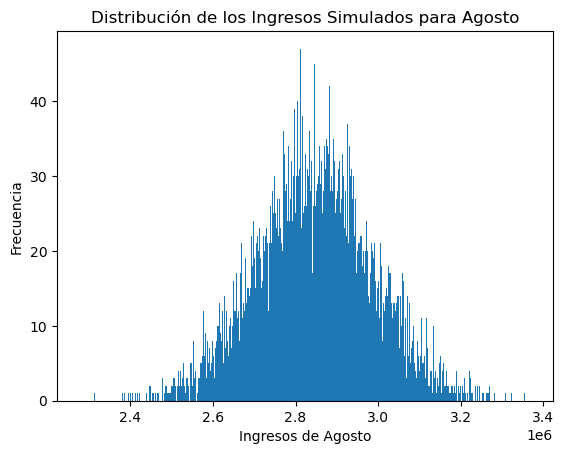

In [27]:
plt.hist(ingresos_agosto, bins = 1000)
plt.xlabel('Ingresos de Agosto')
plt.ylabel('Frecuencia')
plt.title('Distribución de los Ingresos Simulados para Agosto')
plt.show()

Podemos observar que la distribucion del ingreso de agosto tiene forma de campana, lo cual es un primer indicio de que la variable es normal

# Ejercicio 9

In [28]:
roturas_agosto_k_optimo = []

roturas_agosto_k_ingenuo = []

for i in range(N):
    
    s_norte = N_simulaciones[i][0]

    s_sur = N_simulaciones[i][1]

    info_k_optimo = simular_ambos_molinos(s_norte, s_sur, T, k_optimo)

    info_k_ingenuo = simular_ambos_molinos(s_norte, s_sur, T, N)

    rotura_k_optimo = sum(info_k_optimo[0][2]) + sum(info_k_optimo[1][2])

    rotura_k_ingenuo = sum(info_k_ingenuo[0][2]) + sum(info_k_ingenuo[1][2])

    roturas_agosto_k_optimo.append(rotura_k_optimo)
    roturas_agosto_k_ingenuo.append(rotura_k_ingenuo)

print(f"Roturas promedio del molino con k-óptimo: {np.mean(roturas_agosto_k_optimo)/2}")

print(f"Roturas promedio del molino con k-ingenuo: {np.mean(roturas_agosto_k_ingenuo)/2}")

Roturas promedio del molino con k-óptimo: 5.71935
Roturas promedio del molino con k-ingenuo: 9.60135


# Ejercicio 10

In [29]:
actividad_norte = []

actividad_sur = []

for i in range(N):

    s_norte = N_simulaciones[i][0]

    s_sur = N_simulaciones[i][1]

    info_ambos_molinos = simular_ambos_molinos(s_norte, s_sur, T, k_optimo)

    estado_norte = sum(info_ambos_molinos[0][1])

    estado_sur = sum(info_ambos_molinos[1][1])

    actividad_norte.append(estado_norte)
    actividad_sur.append(estado_sur)

print(f"Cantidad promedio de días que el molino norte está inactivo: {365 - np.mean(actividad_norte)}")
print(f"Cantidad promedio de días que el molino sur está inactivo: {365 - np.mean(actividad_sur)}")

Cantidad promedio de días que el molino norte está inactivo: 91.63639999999998
Cantidad promedio de días que el molino sur está inactivo: 92.07940000000002


Vemos que, en promedio, ambos molinos estan encendidos durante 274 dias del año, lo que equivale a decir que ambos suelen estar apagados aproximadamente 90 días del año. Esto quiere decir que alrededor de un tercio del año los molinos no generan ganancias

In [30]:
error_estimacion_norte = estimar_error_muestral(actividad_norte)
error_estimacion_sur = estimar_error_muestral(actividad_sur)

print(f"Error de estimación de la actividad del molino norte: {error_estimacion_norte}")
print(f"Error de estimación de la actividad del molino norte: {error_estimacion_sur}")

Error de estimación de la actividad del molino norte: 0.14036919125999658
Error de estimación de la actividad del molino norte: 0.1403153534145155


# Ejercicio 11

Dado que las roturas de cada molino son eventos independientes, podemos estimar la probabilidad de que ambos estén inactivos como:

$$
P(\text{inactividad el 9 de julio}) = P(N_{189} = 0) \times P(S_{189} = 0)
$$

Donde:

- $N_{189}$ es el estado del molino norte en el día 189 del año (9 de julio)
- $S_{189}$ es el estado del molino sur en el día 189 del año (9 de julio)


Por otro lado, el error de estimación de $\hat{p}$ se puede calcular como:

$$
SE = \sqrt{\frac{\hat{p} \cdot (1 - \hat{p})}{N}}
$$

donde:

- $\hat{p}$ es la estimación de la proporcion deseada
- $N$ es el número de simulaciones

In [31]:
coincidencias_9_julio = 0

for i in range(N):

    s_norte = N_simulaciones[i][0]

    s_sur = N_simulaciones[i][1]

    simulacion_regional = simular_ambos_molinos(s_norte, s_sur, T, k_optimo)

    estado_norte = simulacion_regional[0][1]

    estado_sur = simulacion_regional[1][1]

    if(estado_norte[189] == 0 and estado_sur[189] == 0):
            coincidencias_9_julio += 1

print(coincidencias_9_julio)

coincidencias_9_julio = coincidencias_9_julio/10000

print(coincidencias_9_julio)

probabilidad_inactividad_9_julio = 1/T * coincidencias_9_julio

print(f'Probabilidad de que ambos molinos estén inactivos el 9 de julio: {probabilidad_inactividad_9_julio:.10f}')

SE_9_julio = np.sqrt(probabilidad_inactividad_9_julio * (1 - probabilidad_inactividad_9_julio) / 10000)

print(f'Error estándar de la probabilidad: {SE_9_julio:.10f}')

8
0.0008
Probabilidad de que ambos molinos estén inactivos el 9 de julio: 0.0000021918
Error estándar de la probabilidad: 0.0000148046


Podemos observar que la probabilidad de ambos molinos esten inactivos el 9 de julio es cercana a 0, lo que lo convierte en un evento bastante improbable

Para estimar la probabilidad de que ambos molinos estén inactivos en algún día del año, podemos usar Monte Carlo:

$$
P(\text{inactividad en algún día del año}) = \frac{1}{365} \sum_{i=1}^{365} \mathbb{I}(N_{i} = 0 \cap S_{i} = 0)
$$

Donde:

- $\mathbb{I}$ es la función indicadora que toma el valor 1 si ambos molinos están inactivos en el día $i$ y 0 en caso contrario.
- $N_{i}$ es el estado del molino norte en el día $i$.
- $S_{i}$ es el estado del molino sur en el día $i$.

In [32]:
cantidad_coincidencias = 0

for i in range(N):

    s_norte = N_simulaciones[i][0]

    s_sur = N_simulaciones[i][1]

    simulacion_regional = simular_ambos_molinos(s_norte, s_sur, T, k_optimo)

    estado_norte = simulacion_regional[0][1]

    estado_sur = simulacion_regional[1][1]

    for j in range(T):
        if(estado_norte[j] == 0 and estado_sur[j] == 0):
            cantidad_coincidencias += 1

cantidad_coincidencias_promedio = cantidad_coincidencias/N

probabilidad_inactividad = 1/T * cantidad_coincidencias_promedio
print(f'Probabilidad de que ambos molinos estén inactivos en algun dia del año: {probabilidad_inactividad}')

SE = np.sqrt(probabilidad_inactividad * (1 - probabilidad_inactividad) / N)
print(f'Error estándar de la probabilidad: {SE}')

Probabilidad de que ambos molinos estén inactivos en algun dia del año: 0.17487616438356166
Error estándar de la probabilidad: 0.003798611476764308


# Ejercicio 12

In [33]:
def calcular_correlacion(X, Y):
    # Calcular las medias
    media_X = np.mean(X)
    media_Y = np.mean(Y)
    
    # Calcular las desviaciones estándar
    desvio_X = np.sqrt(np.sum((X - media_X)**2))
    desvio_Y = np.sqrt(np.sum((Y - media_Y)**2))
    
    # Calcular la covarianza
    covarianza = np.sum((X - media_X) * (Y - media_Y))
    
    # Calcular la correlación
    correlacion = covarianza / (desvio_X * desvio_Y)
    
    return correlacion

In [34]:
ingresos_mayo_norte = []
ingresos_mayo_sur = []

for i in range(N):
    
    s_norte = N_simulaciones[i][0]

    s_sur = N_simulaciones[i][1]
    
    # Calcular el VAN diario para mayo (días 121 a 151 del año)
    ingreso_norte = calcular_VAN_sin_descuento(T, s_norte, k_optimo)[0]
    ingreso_sur = calcular_VAN_sin_descuento(T, s_sur, k_optimo)[0]
    
    # Sumar los ingresos diarios para mayo (días 121 a 151)
    ingreso_mensual_norte = ingreso_norte[151] - ingreso_norte[121]

    ingreso_mensual_sur = ingreso_sur[151] - ingreso_sur[121]
    
    # Guardar los totales en listas
    ingresos_mayo_norte.append(ingreso_mensual_norte)
    ingresos_mayo_sur.append(ingreso_mensual_sur)

correlacion = calcular_correlacion(ingresos_mayo_norte, ingresos_mayo_sur)

print(f'Correlación del ingreso mensual de mayo entre los dos molinos: {correlacion}')

Correlación del ingreso mensual de mayo entre los dos molinos: 0.33857498602671754


# Ejercicio 13

La sensibilidad se puede calcular utilizando diferencias finitas de la siguiente manera:

$$
\frac{\partial E[f(\alpha, S_T)]}{\partial \alpha} \approx \frac{E[f(\alpha + \epsilon, S_T)] - E[f(\alpha - \epsilon, S_T)]}{2\epsilon}
$$

Donde:
- $\alpha$ es el parámetro de interés.
- $\epsilon$ es un pequeño incremento.
- $E[f(\alpha, S_T)]$ es el valor esperado de la función \( f \) con el parámetro $\alpha$ y el proceso estocástico \( S_T \).

Para calcular esta sensibilidad, se realizan simulaciones para $\alpha$ + $\epsilon$ y $\alpha$ - $\epsilon$, y se utiliza la fórmula de diferencias finitas para estimar la derivada.

In [35]:
def VAN_esperado_modificado(k, N, T, costo_arreglo,sims):
    simulaciones = sims

    simulaciones_regionales = []

    for i in range(N):
        
        camino_norte = simulaciones[i][0]
        camino_sur = simulaciones[i][1]

        VAN_norte, _, _ = calcular_VAN(T, camino_norte, k, costo_arreglo)
        VAN_sur, _, _ = calcular_VAN(T, camino_sur, k, costo_arreglo)

        simulaciones_regionales.append(VAN_norte[-1] + VAN_sur[-1])

    VAN_esperado = np.mean(simulaciones_regionales)
    return VAN_esperado

def calcular_sensibilidad(costo_arreglo_actual, costo_arreglo_nuevo, N, T, k, simulaciones):

    # Calcular VAN esperado para el costo de arreglo actual
    VAN_esperado_actual = VAN_esperado_modificado(k, N, T, costo_arreglo_actual,simulaciones)
    
    # Calcular VAN esperado para el nuevo costo de arreglo
    VAN_esperado_nuevo = VAN_esperado_modificado(k, N, T, costo_arreglo_nuevo,simulaciones)
    
    # Calcular la sensibilidad utilizando la fórmula de diferencias finitas
    sensibilidad = (VAN_esperado_nuevo - VAN_esperado_actual) / (costo_arreglo_nuevo - costo_arreglo_actual)
    
    return sensibilidad

In [37]:
costo_arreglo_actual = 200000  # Costo viejo
costo_arreglo_nuevo = 250000   # Nuevo costo

sensibilidad = calcular_sensibilidad(costo_arreglo_actual, costo_arreglo_nuevo, N, T, k_optimo, N_simulaciones)

print(f"La sensibilidad calculada es: {sensibilidad}")

La sensibilidad calculada es: -0.5287713980685627


#### Análisis extra

In [40]:
umbrales = np.arange(5, 12, 0.1)

# Gráfico del cambio del VAN y el umbral óptimo para costos entre 0 y 500 mil dólares
costos_arreglo = np.linspace(0, 500000, 19)
VANs_esperados = []
umbrales_optimos = []

for costo in costos_arreglo:

    lista_VANs_total = []

    VAN_esperado_dado_k = VAN_esperado_modificado(k_optimo, N, T, costo, N_simulaciones)

    lista_VANs_total.append((VAN_esperado_dado_k, k_optimo))
    
    VANs_esperados.append(max(lista_VANs_total)[0])


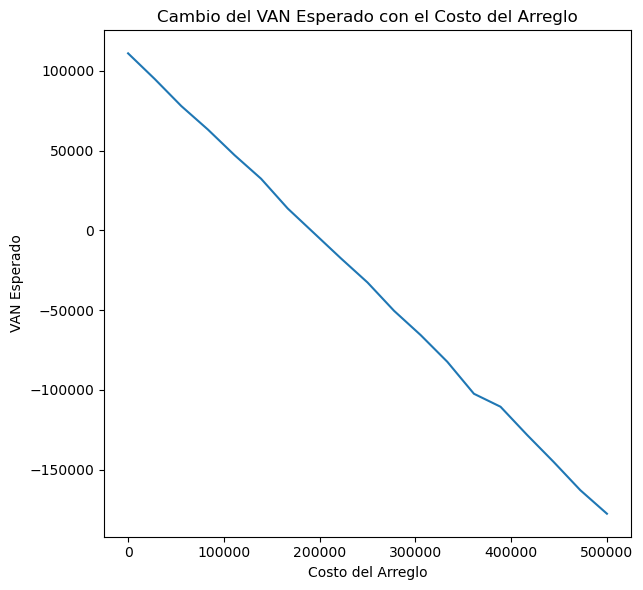

In [41]:

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(costos_arreglo, VANs_esperados)
plt.xlabel('Costo del Arreglo')
plt.ylabel('VAN Esperado')
plt.title('Cambio del VAN Esperado con el Costo del Arreglo')

plt.tight_layout()
plt.show()

In [42]:
umbrales = np.arange(6, 12, 0.1)

lista_VANs_norte = []
lista_VANs_sur = []
lista_VANs_total = []

# Llenar las listas con las tuplas de [VAN, k]
for k in umbrales:

    VAN_esperado_dado_k = VAN_esperado_modificado(k,N,T,250000,N_simulaciones)

    lista_VANs_total.append((VAN_esperado_dado_k,k))

# Encontrar el valor de k más alto considerando VAN y luego k
k_optimo_costo_250 = max(lista_VANs_total, key=lambda x: (x[0], x[1]))[1]  # Max en función de [VAN, k]

print(f"El valor óptimo de k es: {k_optimo_costo_250}")

El valor óptimo de k es: 6.0


Como se observa en el gráfico, hay una relación negativa entre inversamente proporcional entre el costo de arreglo y el ingreso mensual esperado, a medida que aumenta el costo, disminuye el ingreso esperado. Esto indica que cualquier incremento en los costos de reparación tiene un impacto negativo considerable en la rentabilidad del negocio. Particularmente, la pendiente de la recta que muestra la relación entre VAN esperado y costo de arreglo es igual a la sensibilidad -0.5, esto es, por cada dólar que aumenta el costo, disminuye el VAN esperado en 0.5 dólares

Dado que el costo de reparación es ahora más alto, el umbral óptimo para la reparación debería disminuir. Esto significa que deberíamos considerar reparar el molino antes de que se produzcan daños más graves y costosos. Al reducir el umbral, minimizamos el riesgo de enfrentarnos a reparaciones extremadamente costosas.

# Ejercicio 14

Graficamos la media estacional a lo largo del año y el VAN esperado para 10000 simulaciones. Con el fin de mejorar la visualización, dividimos el VAN por un número grande para apreciar de manera mas clara cómo varía en el mismo gráfico que la media estacional.

In [45]:
van_total = [0] * T 

for i in range(N):

    simulacion_norte = N_simulaciones[i][0]
    simulacion_sur = N_simulaciones[i][1]
    
    simulacion_ambos_molinos = simular_ambos_molinos(simulacion_norte,simulacion_sur,T,k_optimo)

    simular_VAN_molino_norte = simulacion_ambos_molinos[0][0]

    simular_VAN_molino_sur = simulacion_ambos_molinos[1][0]

    van_total = [van_total[i] + (simular_VAN_molino_norte[i] + simular_VAN_molino_sur[i])/2 for i in range(T)]  # Suma los VAN diarios

# Calcula el promedio dividiendo cada elemento de van_total por el número de simulaciones (x)
van_acumulado = [total / N for total in van_total]

# Re-escalamos que se aprecie en el grafico (por tema escalas)
van_acumulado = [van / N for van in van_acumulado]

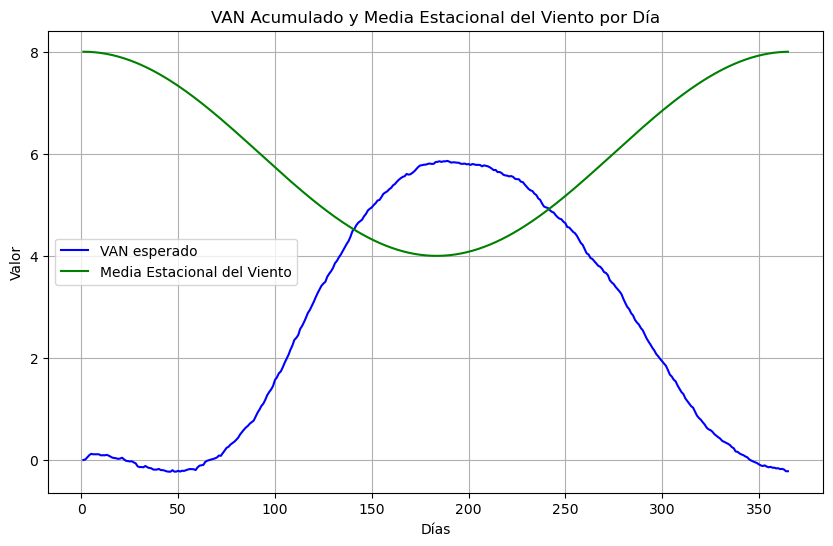

In [46]:
# Graficamos el VAN_esperado junto con la media del viento

media_viento = [] #valor de la media en dia i 

for i in range(T):
    media_viento.append(theta_function(i))

dias = range(1, T+1)  # Días (eje x)

plt.figure(figsize=(10, 6))

# Graficar el VAN acumulado
plt.plot(dias, van_acumulado, label="VAN esperado", color="b")

# Graficar la media del viento
plt.plot(dias, media_viento, label="Media Estacional del Viento", color="g")

# Añadir etiquetas y leyenda
plt.xlabel("Días")
plt.ylabel("Valor")
plt.title("VAN Acumulado y Media Estacional del Viento por Día")
plt.legend()

# Mostrar el gráfico
plt.grid(True)
plt.show()